In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import requests, zipfile, io

# Daily Challenge: Pokemon Win Prediction Analysis

## Data Preparation

In [170]:
# Download and Extract Zipfile Containing Datasets
url = 'https://github.com/devtlv/Datasets-GEN-AI-Bootcamp/raw/refs/heads/main/Week%205/Day%204%20-%20Statistics%20for%20Machine%20Learning/Pokemon%20Data%20Analysis%20Tutorial.zip'
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("data")

In [171]:
# Load and Merge Pokemon/Combats Dataset
df_pokemon = pd.read_csv(r'C:\Repositories\DI-Bootcamp\Week12\Pokemon\data\Pokemon Data Analysis Tutorial\pokemon.csv')
df_combat = pd.read_csv(r'C:\Repositories\DI-Bootcamp\Week12\Pokemon\data\Pokemon Data Analysis Tutorial\combats.csv')

# Fill Missing Name for Pokemon 62
df_pokemon.loc[62, 'Name'] = 'Primeape'

# Replace Null Values with 'None' in Type 2
df_pokemon = df_pokemon.fillna('None')

In [172]:
# Merge combat data with pokemon data for the first pokemon
combats_merged = df_combat.merge(
    df_pokemon, 
    left_on='First_pokemon', 
    right_on='#', 
    how='left',
    suffixes=('', '_first')
)

# Rename columns to indicate they're for the first pokemon
first_pokemon_cols = {col: f'First_{col}' for col in df_pokemon.columns if col != '#'}
combats_merged = combats_merged.rename(columns=first_pokemon_cols)

# Merge with pokemon data for the second pokemon
combats_merged = combats_merged.merge(
    df_pokemon,
    left_on='Second_pokemon',
    right_on='#',
    how='left',
    suffixes=('', '_second')
)

# Rename columns to indicate they're for the second pokemon
second_pokemon_cols = {col: f'Second_{col}' for col in df_pokemon.columns if col != '#'}
df = combats_merged.rename(columns=second_pokemon_cols)

# Drop Repeating/Unecessary Columns
df = df.drop(columns=['#', '#_second'])

# Check
print(df.shape)
df.head(20)

(50000, 25)


,First_pokemon,Second_pokemon,Winner,First_Name,First_Type 1,First_Type 2,First_HP,First_Attack,First_Defense,First_Sp. Atk,First_Sp. Def,First_Speed,First_Generation,First_Legendary,Second_Name,Second_Type 1,Second_Type 2,Second_HP,Second_Attack,Second_Defense,Second_Sp. Atk,Second_Sp. Def,Second_Speed,Second_Generation,Second_Legendary
0,266,298,298,Larvitar,Rock,Ground,50,64,50,45,50,41,2,False,Nuzleaf,Grass,Dark,70,70,40,60,40,60,3,False
1,702,701,701,Virizion,Grass,Fighting,91,90,72,90,129,108,5,True,Terrakion,Rock,Fighting,91,129,90,72,90,108,5,True
2,191,668,668,Togetic,Fairy,Flying,55,40,85,80,105,40,2,False,Beheeyem,Psychic,None,75,75,75,125,95,40,5,False
3,237,683,683,Slugma,Fire,None,40,40,40,70,40,20,2,False,Druddigon,Dragon,None,77,120,90,60,90,48,5,False
4,151,231,151,Omastar,Rock,Water,70,60,125,115,70,55,1,False,Shuckle,Bug,Rock,20,10,230,10,230,5,2,False
5,657,752,657,Joltik,Bug,Electric,50,47,50,57,50,65,5,False,Aegislash Shield Forme,Steel,Ghost,60,50,150,50,150,60,6,False
6,192,134,134,Natu,Psychic,Flying,40,50,45,70,45,70,2,False,Jynx,Ice,Psychic,65,50,35,115,95,95,1,False
7,73,545,545,Machop,Fighting,None,70,80,50,35,35,35,1,False,Giratina Altered Forme,Ghost,Dragon,150,100,120,100,120,90,4,True
8,220,763,763,Pineco,Bug,None,50,65,90,35,35,15,2,False,Clauncher,Water,None,50,53,62,58,63,44,6,False
9,302,31,31,Wingull,Water,Flying,40,30,30,55,30,85,3,False,Pikachu,Electric,None,35,55,40,50,50,90,1,False


In [173]:
# Count total wins for each Pokémon
wins = df['Winner'].value_counts()

# Count total appearances (as First or Second Pokémon)
appearances = pd.concat([
    df['First_pokemon'],
    df['Second_pokemon']
]).value_counts()

# Combine into a single DataFrame
stats = pd.DataFrame({
    'Wins': wins,
    'Battles': appearances
})

# Calculate win percentage
stats['Win%'] = (stats['Wins'] / stats['Battles']) * 100

# Fill any missing values (Pokémon that never won)
stats = stats.fillna(0)

# Show the first few
print(stats.sort_values(by='Win%', ascending=True))

      Wins  Battles       Win%
231    0.0      135   0.000000
290    3.0      138   2.173913
190    3.0      122   2.459016
639    4.0      129   3.100775
237    4.0      123   3.252033
..     ...      ...        ...
154  136.0      141  96.453901
20   115.0      119  96.638655
704  121.0      125  96.800000
513  116.0      119  97.478992
155  127.0      129  98.449612

[784 rows x 3 columns]


## Exploratory Data Analysis

In [ ]:
# Merge Win Percentage to Pokemons
df_pokemon = df_pokemon.merge(
    stats,
    left_on='#',
    right_index=True,
    how='left'
)

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Wins,Battles,Win%
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,37.0,133.0,27.819549
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False,46.0,121.0,38.016529
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False,89.0,132.0,67.424242
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False,70.0,125.0,56.000000
4,5,Charmander,Fire,None,39,52,43,60,50,65,1,False,55.0,112.0,49.107143


In [186]:
# Create a Correlation Matrix to Identify Relationships Between Stats and Win%
cols = ['HP', 'Attack', 'Speed', 'Win%']
for col in cols:
    corr_value = df_pokemon[col].corr(df_pokemon['Win%'])
    print(f"Correlation between {col} and Win%: {corr_value:.3f}")

# Corr as Matrix
corr_matrix = df_pokemon[cols].corr()
print('\n', corr_matrix)

Correlation between HP and Win%: 0.262
Correlation between Attack and Win%: 0.503
Correlation between Speed and Win%: 0.938
Correlation between Win% and Win%: 1.000

               HP    Attack     Speed      Win%
HP      1.000000  0.422386  0.175952  0.261602
Attack  0.422386  1.000000  0.381240  0.502825
Speed   0.175952  0.381240  1.000000  0.938055
Win%    0.261602  0.502825  0.938055  1.000000


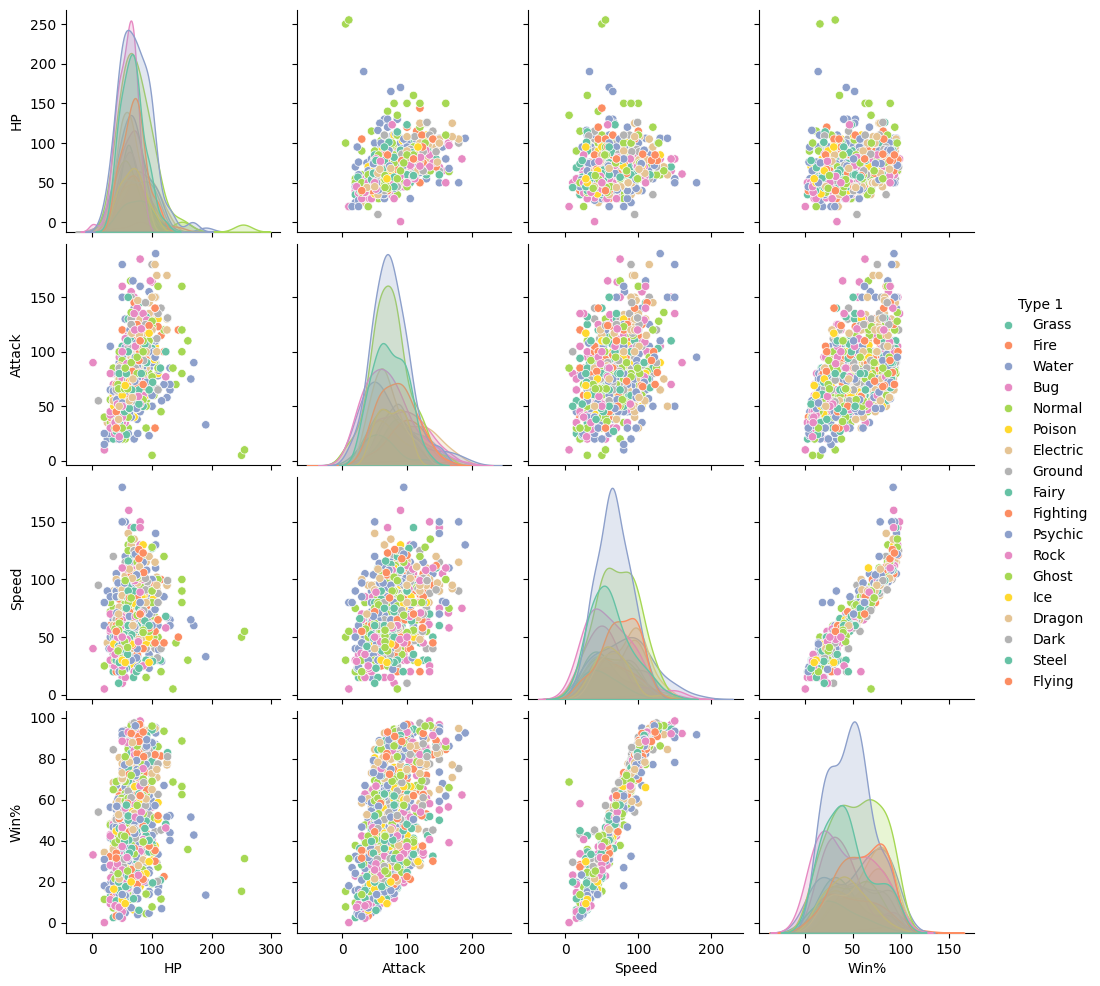

In [193]:
# Plot a Seaborn pairplot or PairGrid for stats vs. win percentage.
sns.pairplot(
    df_pokemon,
    vars=['HP', 'Attack', 'Speed', 'Win%'],
    diag_kind="kde",
    hue='Type 1',
    palette='Set2'
)
plt.show()

In [191]:
# Analyze the top 10 Pokemon by win percentage and their stats.
top_10 = df_pokemon.sort_values(by='Win%', ascending=False).head(10)

display(top_10)
top_10.describe()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Wins,Battles,Win%
154,155,Mega Aerodactyl,Rock,Flying,80,135,85,70,95,150,1,False,127.0,129.0,98.449612
512,513,Weavile,Dark,Ice,70,120,65,45,85,125,4,False,116.0,119.0,97.478992
703,704,Tornadus Therian Forme,Flying,None,79,100,80,110,90,121,5,True,121.0,125.0,96.800000
19,20,Mega Beedrill,Bug,Poison,65,150,40,15,80,145,1,False,115.0,119.0,96.638655
153,154,Aerodactyl,Rock,Flying,80,105,65,60,75,130,1,False,136.0,141.0,96.453901
476,477,Mega Lopunny,Normal,Fighting,65,136,94,54,96,135,4,False,124.0,129.0,96.124031
726,727,Greninja,Water,Dark,72,95,67,103,71,122,6,False,122.0,127.0,96.062992
716,717,Meloetta Pirouette Forme,Normal,Fighting,100,128,90,77,77,128,5,False,118.0,123.0,95.934959
164,165,Mega Mewtwo Y,Psychic,None,106,150,70,194,120,140,1,True,119.0,125.0,95.200000
349,350,Mega Sharpedo,Water,Dark,70,140,70,110,65,105,3,False,114.0,120.0,95.000000


,#,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Wins,Battles,Win%
count,10.00000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,398.20000,78.700000,125.900000,72.60000,83.800000,85.400000,130.100000,3.100000,121.200000,125.700000,96.414314
std,266.90939,14.040022,20.129856,15.60769,49.233683,15.826841,13.118689,1.969207,6.613118,6.566751,1.021379
min,20.00000,65.000000,95.000000,40.00000,15.000000,65.000000,105.000000,1.000000,114.000000,119.000000,95.000000
25%,157.50000,70.000000,108.750000,65.50000,55.500000,75.500000,122.750000,1.000000,116.500000,120.750000,95.966968
50%,413.50000,75.500000,131.500000,70.00000,73.500000,82.500000,129.000000,3.500000,120.000000,125.000000,96.288966
75%,656.25000,80.000000,139.000000,83.75000,108.250000,93.750000,138.750000,4.750000,123.500000,128.500000,96.759664
max,727.00000,106.000000,150.000000,94.00000,194.000000,120.000000,150.000000,6.000000,136.000000,141.000000,98.449612
